In [178]:
from VariationalBayes.Parameters import ScalarParam, ModelParamsDict, VectorParam, PosDefMatrixParam
from VariationalBayes.NormalParams import UVNParam, UVNParamVector
from VariationalBayes.ExponentialFamilies import UnivariateNormalEntropy, UVNPrior

import autograd
import autograd.numpy as np
import scipy as sp

import copy
from scipy import optimize

import matplotlib.pyplot as plt
%matplotlib inline

The ELBO is given by:

$$
E\left(q\right)=-\frac{1}{2}\left(\left(\mu_{\theta}^{2}+v_{\theta}^{2}\right)\Lambda_{\theta}+\left(\mu_{z}^{2}+v_{z}^{2}\right)\Lambda_{z}+2\mu_{\theta}\mu_{z}\Lambda_{\theta z}\right)+\frac{1}{2}\log v_{\theta}^{2}+\frac{1}{2}\log v_{z}^{2}
$$



In [208]:
def gauss_log_prob(theta, z, info_mat):
    s, logdet = np.linalg.slogdet(info_mat)
    assert(s > 0)
    return -0.5 * (info_mat[0, 0] * theta**2 + info_mat[1, 1] * z**2 + 2 * info_mat[1, 0] * theta * z) \
        + 0.5 * logdet

def banana_log_prob(theta_exp, z, info_mat, include_jacobian=True):
    theta = np.log(theta_exp)
    return gauss_log_prob(theta, z, info_mat) - include_jacobian * theta


In [162]:
corr = 0.95 # The correlation
ellipticity = 1.0 # The ratio of the theta scale to the z scale
scale = 0.6 # The overall scale
assert(np.abs(corr) < 1)
assert(ellipticity > 0)
cov_scale = scale * np.diag([1.0, ellipticity])
corr_mat = np.eye(2)
corr_mat[0, 1] = corr_mat[1, 0] = corr
cov_mat = np.matmul(cov_scale, np.matmul(corr_mat, cov_scale)) 
info_mat = np.linalg.inv(cov_mat)

print(cov_mat)

[[ 0.36   0.342]
 [ 0.342  0.36 ]]


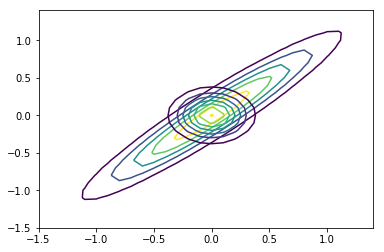

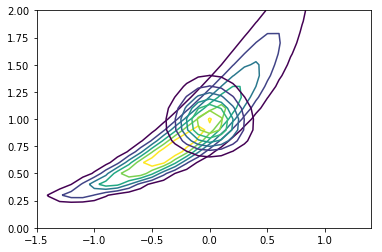

In [206]:
grid_points = np.arange(-2.5 * scale, 2.5 * scale, 0.1)
theta_grid, z_grid = np.meshgrid(grid_points, grid_points)
grid_points_b = np.arange(0.000001, np.exp(1.2 * scale), 0.1)
theta_b_grid, z_b_grid = np.meshgrid(grid_points_b, grid_points)

glp = gauss_log_prob(theta_grid, z_grid, info_mat)
blp = banana_log_prob(theta_b_grid, z_b_grid, info_mat)

plt.figure()
plt.contour(z_grid, theta_grid, np.exp(glp))

plt.figure()
plt.contour(z_b_grid, theta_b_grid, np.exp(blp))


1.19806655518
1.19721736312


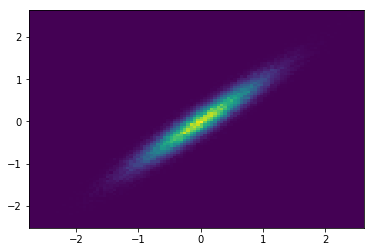

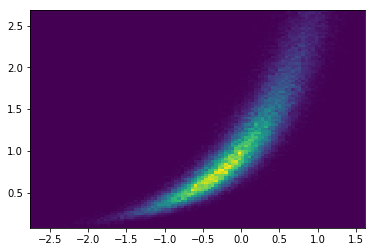

In [170]:
num_draws = int(1e5)
draws = np.random.multivariate_normal(np.array([0., 0.]), cov_mat, num_draws)
theta_draws = draws[:, 0]
exp_theta_draws = np.exp(theta_draws)
z_draws = draws[:, 1]

plt.figure()
plt.hist2d(z_draws, theta_draws, bins=100);

plt.figure()
keep_rows = exp_theta_draws < np.percentile(exp_theta_draws, 95)
plt.hist2d(z_draws[keep_rows], exp_theta_draws[keep_rows], bins=100);


In [212]:

def gauss_log_prob_wrapper(par):
    return -1 * gauss_log_prob(par[0], par[1], info_mat)

def banana_log_prob_wrapper(par, include_jacobian=True):
    if par[0] <= 0:
        return float('inf')
    return -1 * banana_log_prob(par[0], par[1], info_mat, include_jacobian=include_jacobian)

glp_opt = sp.optimize.minimize(gauss_log_prob_wrapper, method='Nelder-Mead', x0=[0.1, 0.2])
print(glp_opt.x)

blp_opt = sp.optimize.minimize(banana_log_prob_wrapper, method='Nelder-Mead', x0=[1.0, 0.2])
print(blp_opt.x)

# Note that the Jacobian means the MAP isn't invariant to reparameterizations.
blp_no_jac_opt = \
    sp.optimize.minimize(lambda par: banana_log_prob_wrapper(par, include_jacobian=False), 
                         method='Nelder-Mead', x0=[1.0, 0.2])
print(blp_no_jac_opt.x)


banana_log_prob_wrapper_hessian = autograd.hessian(banana_log_prob_wrapper)
blp_hess = banana_log_prob_wrapper_hessian(blp_opt.x)
blp_hess_cov = np.linalg.inv(blp_hess)

gauss_log_prob_wrapper_hessian = autograd.hessian(gauss_log_prob_wrapper)
glp_hess = gauss_log_prob_wrapper_hessian(glp_opt.x)
glp_hess_cov = np.linalg.inv(glp_hess)

print(glp_hess_cov)
print(cov_mat)

[ -4.01311861e-05  -3.23342060e-05]
[ 0.69760143 -0.34208864]
[  1.00001552e+00  -1.97567073e-06]
[  3.93376409e-05   3.51004101e-02   3.75335221e-05   3.50991099e-02]
[[ 0.36   0.342]
 [ 0.342  0.36 ]]
[[ 0.36   0.342]
 [ 0.342  0.36 ]]


In [236]:
def kl_divergence(theta_mu, theta_var, z_mu, z_var, info_mat):
    theta_entropy = 0.5 * np.log(theta_var)
    z_entropy = 0.5 * np.log(z_var)
    e_log_prob = -0.5 * ((theta_mu**2 + theta_var) * info_mat[0, 0] + (z_mu**2 + z_var) * info_mat[1, 1] \
                          + 2 * theta_mu * z_mu * info_mat[1, 0])
    
    return -1 * (e_log_prob + theta_entropy + z_entropy) 

def unwrap_vb_params(par):
    theta_mu = par[0]
    theta_var = par[1]
    z_mu = par[2]
    z_var = par[3]
    return theta_mu, theta_var, z_mu, z_var

def kl_wrapper(par):
    theta_mu, theta_var, z_mu, z_var = unwrap_vb_params(par)
    if theta_var < 0 or z_var < 0:
        return float('inf')
    return kl_divergence(theta_mu, theta_var, z_mu, z_var, info_mat)

def transformed_moments(par):
    theta_mu, theta_var, z_mu, z_var = unwrap_vb_params(par)
    e_exp_theta = np.exp(theta_mu + 0.5 * theta_var)
    return np.array([e_exp_theta, z_mu])

kl_opt = sp.optimize.minimize(kl_wrapper, method='Nelder-Mead', x0=[1.0, 0.2, 0.1, 0.2])
theta_mu, theta_var, z_mu, z_var = unwrap_vb_params(kl_opt.x)

print('The VB posterior means are zero:')
print(theta_mu)
print(z_mu)


print('The VB posterior variances are the inverse of the information matrix:')
print(theta_var, ' vs ', 1 / info_mat[0, 0])
print(z_var, ' vs ', 1 / info_mat[1, 1])

# Get the linear response correction.
kl_wrapper_hessian = autograd.hessian(kl_wrapper)
kl_hessian = kl_wrapper_hessian(kl_opt.x)
lrvb_cov = np.linalg.inv(kl_hessian)
lrvb_theta_mu, lrvb_theta_var, lrvb_z_mu, lrvb_z_var = unwrap_vb_params(np.diag(lrvb_cov))

transformed_moment_jacobian = autograd.jacobian(transformed_moments)
moment_jac = transformed_moment_jacobian(kl_opt.x)
e_exp_theta, e_z = transformed_moments(kl_opt.x)

exp_theta_z_cov = np.matmul(moment_jac, np.linalg.solve(kl_hessian, moment_jac.T))




The VB posterior means are zero:
3.93376409345e-05
3.75335220868e-05
The VB posterior variances are the inverse of the information matrix:
0.0351004101123  vs  0.0351
0.0350991099323  vs  0.0351


In [246]:
def q_log_prob(theta, z, info_mat):
    return -0.5 * (z**2) * info_mat[1, 1] - 0.5 * (theta**2) * info_mat[0, 0] + \
           0.5 * np.log(info_mat[0, 0]) + 0.5 * np.log(info_mat[1, 1])

def q_banana_log_prob(theta_exp, z, info_mat, include_jacobian=True):
    theta = np.log(theta_exp)
    return q_log_prob(theta, z, info_mat) - include_jacobian * theta

def q_log_lrvb_approx(theta_exp, z, e_exp_theta, e_z, exp_theta_z_cov):
    exp_theta_z_info = np.linalg.inv(exp_theta_z_cov)
    return -0.5 * (exp_theta_z_info[0, 0] * (theta_exp - e_exp_theta) ** 2 + \
                   2 * exp_theta_z_info[1, 0] * (theta_exp - e_exp_theta) * (z - e_z) +
                   exp_theta_z_info[1, 1] * (z - e_z) ** 2)


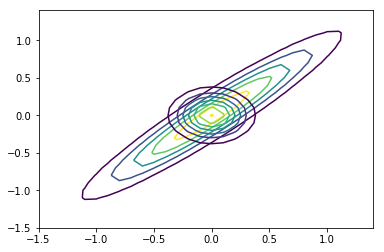

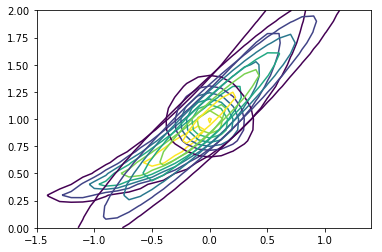

In [247]:
qlp = q_log_prob(theta_grid, z_grid, info_mat)
qblp = q_banana_log_prob(theta_b_grid, z_b_grid, info_mat)
qb_lrvp_lp = q_log_lrvb_approx(theta_b_grid, z_b_grid, e_exp_theta, e_z, exp_theta_z_cov)

plt.figure()
plt.contour(z_grid, theta_grid, np.exp(glp))
plt.contour(z_grid, theta_grid, np.exp(qlp))

plt.figure()
plt.contour(z_b_grid, theta_b_grid, np.exp(blp))
plt.contour(z_b_grid, theta_b_grid, np.exp(qblp))

plt.figure()
plt.contour(z_b_grid, theta_b_grid, np.exp(blp))
plt.contour(z_b_grid, theta_b_grid, np.exp(qb_lrvp_lp))


In this case, we know that the distribution of $\exp(\theta)$ is lognormal, so

$$
P(\theta) = \mathcal{N}(0, V_\theta)\\
\mathbb{E}[\exp(\theta)] = \exp\left(\frac{V_\theta ^ 2}{2} \right)\\
\mathrm{Var}(\exp(\theta)) = \left(\exp(V_\theta ^ 2) - 1 \right) \exp(V_\theta ^ 2)
$$

If $\Lambda=\Sigma^{-1}$ is the inverse of the covariance matrix of $(\theta, z)$, then the optimal variational approximation is given by

$$
q(\theta) = \mathcal{N}(0, \Lambda_\theta^{-1})\\
q(z) = \mathcal{N}(0, \Lambda_z^{-1}).
$$

See the notes for derivation.  In nutshell, because we are in the exponential family, and because the KL divergence is invariant to reparameterization (unlike the MAP), the variational approximation in the transformed space is the same as in the original Gaussian space which is given by standard results.

In [234]:

def lognormal_mean(v):
    return np.exp(0.5 * v)

def lognormal_var(v):
    return np.exp(v) * (np.exp(v) - 1)


print("True mean:\t\t", lognormal_mean(cov_mat[0, 0]))
print("Sample mean:\t\t", np.mean(exp_theta_draws))
print("MAP estimate:\t\t", blp_opt.x[0])
print("VB mean:  \t\t", lognormal_mean(1. / info_mat[0, 0]))

print('\n')
print('True var:\t\t', lognormal_var(cov_mat[0, 0]))
print('Sample var:\t\t', np.var(exp_theta_draws))
print('MAP var:\t\t', blp_hess_cov[0, 0])
print("VB var:  \t\t", exp_theta_z_cov[0, 0])


True mean:		 1.19721736312
Sample mean:		 1.19806655518
MAP estimate:		 0.697601425656
VB mean:  		 1.01770490612


True var:		 0.621103796084
Sample var:		 0.622591269044
MAP var:		 0.175151590973
VB var:  		 0.373527944404
